<a href="https://colab.research.google.com/github/Lameuta/PlayAroundWithKanVision/blob/main/Train_and_test_a_ReLuKan_based_model_emnist8748.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
from typing import List, Tuple, Union
import torch.nn.functional as FU
import math
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import os
from PIL import Image
from torchvision.datasets.imagenet import parse_devkit_archive, parse_train_archive, parse_val_archive

In [20]:
train_data = datasets.EMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None, # you can transform labels as well
    split = "balanced"
)

# Setup testing data
test_data = datasets.EMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor(),
    split= "balanced"
)

In [3]:
device = "cuda"

In [4]:
# Credits to: https://github.com/detkov/Convolution-From-Scratch/
import torch
import numpy as np
from typing import List, Tuple, Union

def calc_out_dims(matrix, kernel_side, stride, dilation, padding):
    batch_size, n_channels, n, m = matrix.shape
    h_out = np.floor((n + 2 * padding[0] - kernel_side - (kernel_side - 1) * (dilation[0] - 1)) / stride[0]).astype(int) + 1
    w_out = np.floor((m + 2 * padding[1] - kernel_side - (kernel_side - 1) * (dilation[1] - 1)) / stride[1]).astype(int) + 1
    return h_out, w_out, batch_size, n_channels

def kan_conv2d(matrix: torch.Tensor,
               kernel,
               kernel_side: int,
               stride: Tuple[int, int] = (1, 1),
               dilation: Tuple[int, int] = (1, 1),
               padding: Tuple[int, int] = (0, 0),
               device: str = "cuda") -> torch.Tensor:
    """Performs a 2D convolution with the kernel over the matrix using defined stride, dilation, and padding along axes.

    Args:
        matrix (torch.Tensor): 4D tensor to be convolved (batch_size, channels, height, width).
        kernel (function): Function representing the convolution kernel.
        kernel_side (int): Size of the kernel (assumed to be square).
        stride (Tuple[int, int], optional): Stride along axes. Defaults to (1, 1).
        dilation (Tuple[int, int], optional): Dilation along axes. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Padding along axes. Defaults to (0, 0).
        device (str, optional): Device to perform computation on. Defaults to "cuda".

    Returns:
        torch.Tensor: 4D tensor after convolution.
    """
    h_out, w_out, batch_size, n_channels = calc_out_dims(matrix, kernel_side, stride, dilation, padding)
    matrix_out = torch.zeros((batch_size, n_channels, h_out, w_out)).to(device)
    unfold = torch.nn.Unfold((kernel_side, kernel_side), dilation=dilation, padding=padding, stride=stride)

    for channel in range(n_channels):
        conv_groups = unfold(matrix[:, channel, :, :].unsqueeze(1)).transpose(1, 2)
        for k in range(batch_size):
            matrix_out[k, channel, :, :] = kernel(conv_groups[k, :, :]).reshape((h_out, w_out))
    return matrix_out

def multiple_convs_kan_conv2d(matrix: torch.Tensor,
                              kernels: List[callable],
                              kernel_side: int,
                              stride: Tuple[int, int] = (1, 1),
                              dilation: Tuple[int, int] = (1, 1),
                              padding: Tuple[int, int] = (0, 0),
                              device: str = "cuda") -> torch.Tensor:
    """Performs multiple 2D convolutions with different kernels over the matrix using defined stride, dilation, and padding along axes.

    Args:
        matrix (torch.Tensor): 4D tensor to be convolved (batch_size, channels, height, width).
        kernels (List[callable]): List of functions representing the convolution kernels.
        kernel_side (int): Size of the kernels (assumed to be square).
        stride (Tuple[int, int], optional): Stride along axes. Defaults to (1, 1).
        dilation (Tuple[int, int], optional): Dilation along axes. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Padding along axes. Defaults to (0, 0).
        device (str, optional): Device to perform computation on. Defaults to "cuda".

    Returns:
        torch.Tensor: 4D tensor after multiple convolutions.
    """
    h_out, w_out, batch_size, n_channels = calc_out_dims(matrix, kernel_side, stride, dilation, padding)
    n_convs = len(kernels)
    matrix_out = torch.zeros((batch_size, n_channels * n_convs, h_out, w_out)).to(device)

    for i, kernel in enumerate(kernels):
        conv_result = kan_conv2d(matrix, kernel, kernel_side, stride, dilation, padding, device)
        matrix_out[:, i * n_channels:(i + 1) * n_channels, :, :] = conv_result
    return matrix_out


In [5]:

class ConvReLUKANLayer(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 g: int,
                 k: int,
                 n_convs: int = 1,
                 kernel_size: tuple = (3, 3),
                 stride: tuple = (1, 1),
                 padding: tuple = (1, 1),
                 dilation: tuple = (1, 1)):
        super(ConvReLUKANLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.g = g
        self.k = k
        self.n_convs = n_convs
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        # Initialize the start (S) and end (E) matrices as trainable parameters
        self.S = nn.Parameter(torch.linspace(0, 1, g + k).repeat(in_channels, 1))
        self.E = nn.Parameter(torch.linspace(0, 1, g + k).repeat(in_channels, 1))

        # Initialize the convolution layers
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding, dilation)
            for i in range(n_convs)
        ])

        # Weight matrix Wc for the final convolution step
        self.Wc = nn.Parameter(torch.randn(out_channels, g + k))

        # Normalization constant r
        self.r = 16 * g ** 4 / (k + 1) ** 4

    def forward(self, x):
      self.device = x.device
      if self.n_convs>1:
          return multiple_convs_kan_conv2d(x, self.convs,self.kernel_size[0],self.stride,self.dilation,self.padding,self.device)

        # If there is only one convolution, apply it
      return self.convs[0].forward(x)




In [33]:
class ConvReLUKAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = ConvReLUKANLayer(in_channels=1, out_channels=64, g=10, k=6, n_convs=1)
        self.layer2 = ConvReLUKANLayer(in_channels=64, out_channels=64, g=10, k=6, n_convs=1)
        self.layer3 = ConvReLUKANLayer(in_channels=64, out_channels=64, g=10, k=6, n_convs=1)
        self.layer4 = ConvReLUKANLayer(in_channels=64, out_channels=128, g=10, k=6, n_convs=1)
        self.layer5 = ConvReLUKANLayer(in_channels=128, out_channels=256, g=10, k=6, n_convs=1)

        # Final fully connected layer to produce 4 output classes
        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()
        # Adjust the in_features based on the size of the flattened output
        self.linear1 = nn.Linear(256, 256)
        self.linear2 = nn.Linear(256, 47)

    def forward(self, x):
        x = self.layer1(x)
        #x= self.pool1(x)
        x = self.layer2(x)
        x = self.pool1(x)

        x = self.layer3(x)
        x = self.pool1(x)

        x = self.layer4(x)
        x = self.pool1(x)

        x = self.layer5(x)
        x = self.pool1(x)

        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = FU.log_softmax(x, dim=1)
        return x

In [7]:
def train_and_test(model, train_loader, test_loader, num_epochs, device, save_path='7layersrelukan16g4k.pth'):
    # Loss Function and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_test_accuracy = 0.0  # Track the best test accuracy

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / total_train
        train_accuracy = correct_train / total_train

        # Testing/Validation Phase
        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Testing'):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_loss = running_loss / total_test
        test_accuracy = correct_test / total_test

        # Print Results After Each Epoch
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}\n')

        # Save the model if it has the best test accuracy
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            torch.save(model.state_dict(), save_path)
            print(f'Best model saved with test accuracy: {best_test_accuracy:.4f}\n')

In [8]:
class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Assuming the structure: root_dir/class_name/image_name.jpg
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(class_name)

        # Encode labels as integers if needed
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(set(self.labels)))}
        self.labels = [self.class_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)  # Convert to grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [9]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [21]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 64

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x781f787183d0>, <torch.utils.data.dataloader.DataLoader object at 0x781f7871b760>)
Length of train dataloader: 1763 batches of 64
Length of test dataloader: 294 batches of 64


In [34]:
# Assuming the model and data loaders are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ConvReLUKAN()
model.to(device)



# Train and Test the model
train_and_test(model, train_dataloader, test_dataloader, num_epochs=10, device=device)

cuda


Epoch 1/10 - Testing: 100%|██████████| 294/294 [00:02<00:00, 108.34it/s]


Epoch 1/10
Train Loss: 0.5999, Train Accuracy: 0.8028
Test Loss: 0.4629, Test Accuracy: 0.8453

Best model saved with test accuracy: 0.8453



Epoch 2/10 - Testing: 100%|██████████| 294/294 [00:02<00:00, 105.70it/s]


Epoch 2/10
Train Loss: 0.3882, Train Accuracy: 0.8620
Test Loss: 0.3906, Test Accuracy: 0.8638

Best model saved with test accuracy: 0.8638



Epoch 3/10 - Testing: 100%|██████████| 294/294 [00:03<00:00, 85.52it/s]


Epoch 3/10
Train Loss: 0.3472, Train Accuracy: 0.8739
Test Loss: 0.4026, Test Accuracy: 0.8615



Epoch 4/10 - Testing: 100%|██████████| 294/294 [00:02<00:00, 102.18it/s]


Epoch 4/10
Train Loss: 0.3188, Train Accuracy: 0.8814
Test Loss: 0.3818, Test Accuracy: 0.8685

Best model saved with test accuracy: 0.8685



Epoch 5/10 - Testing: 100%|██████████| 294/294 [00:02<00:00, 109.89it/s]


Epoch 5/10
Train Loss: 0.2927, Train Accuracy: 0.8887
Test Loss: 0.3740, Test Accuracy: 0.8674



Epoch 6/10 - Testing: 100%|██████████| 294/294 [00:02<00:00, 108.35it/s]


Epoch 6/10
Train Loss: 0.2748, Train Accuracy: 0.8940
Test Loss: 0.3666, Test Accuracy: 0.8748

Best model saved with test accuracy: 0.8748



Epoch 7/10 - Testing: 100%|██████████| 294/294 [00:02<00:00, 108.41it/s]


Epoch 7/10
Train Loss: 0.2532, Train Accuracy: 0.9007
Test Loss: 0.3993, Test Accuracy: 0.8667



Epoch 8/10 - Testing: 100%|██████████| 294/294 [00:02<00:00, 99.54it/s]


Epoch 8/10
Train Loss: 0.2402, Train Accuracy: 0.9054
Test Loss: 0.4078, Test Accuracy: 0.8699



Epoch 9/10 - Testing: 100%|██████████| 294/294 [00:03<00:00, 88.20it/s] 


Epoch 9/10
Train Loss: 0.2279, Train Accuracy: 0.9092
Test Loss: 0.4539, Test Accuracy: 0.8627



Epoch 10/10 - Testing: 100%|██████████| 294/294 [00:02<00:00, 108.31it/s]

Epoch 10/10
Train Loss: 0.2143, Train Accuracy: 0.9137
Test Loss: 0.4790, Test Accuracy: 0.8665



In [35]:
labels_list=test_data.classes
labels_list

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'd',
 'e',
 'f',
 'g',
 'h',
 'n',
 'q',
 'r',
 't']

In [36]:
best_model = ConvReLUKAN()
best_model.load_state_dict(torch.load('7layersrelukan16g4k.pth', weights_only= True))
y_preds = []
best_model.to(device)
best_model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = best_model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 294/294 [00:02<00:00, 112.12it/s]


mlxtend version: 0.23.1
0.23.1


<ipython-input-40-514a19b8f8a8>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_tensor = torch.tensor(y_pred_tensor)


1175.0


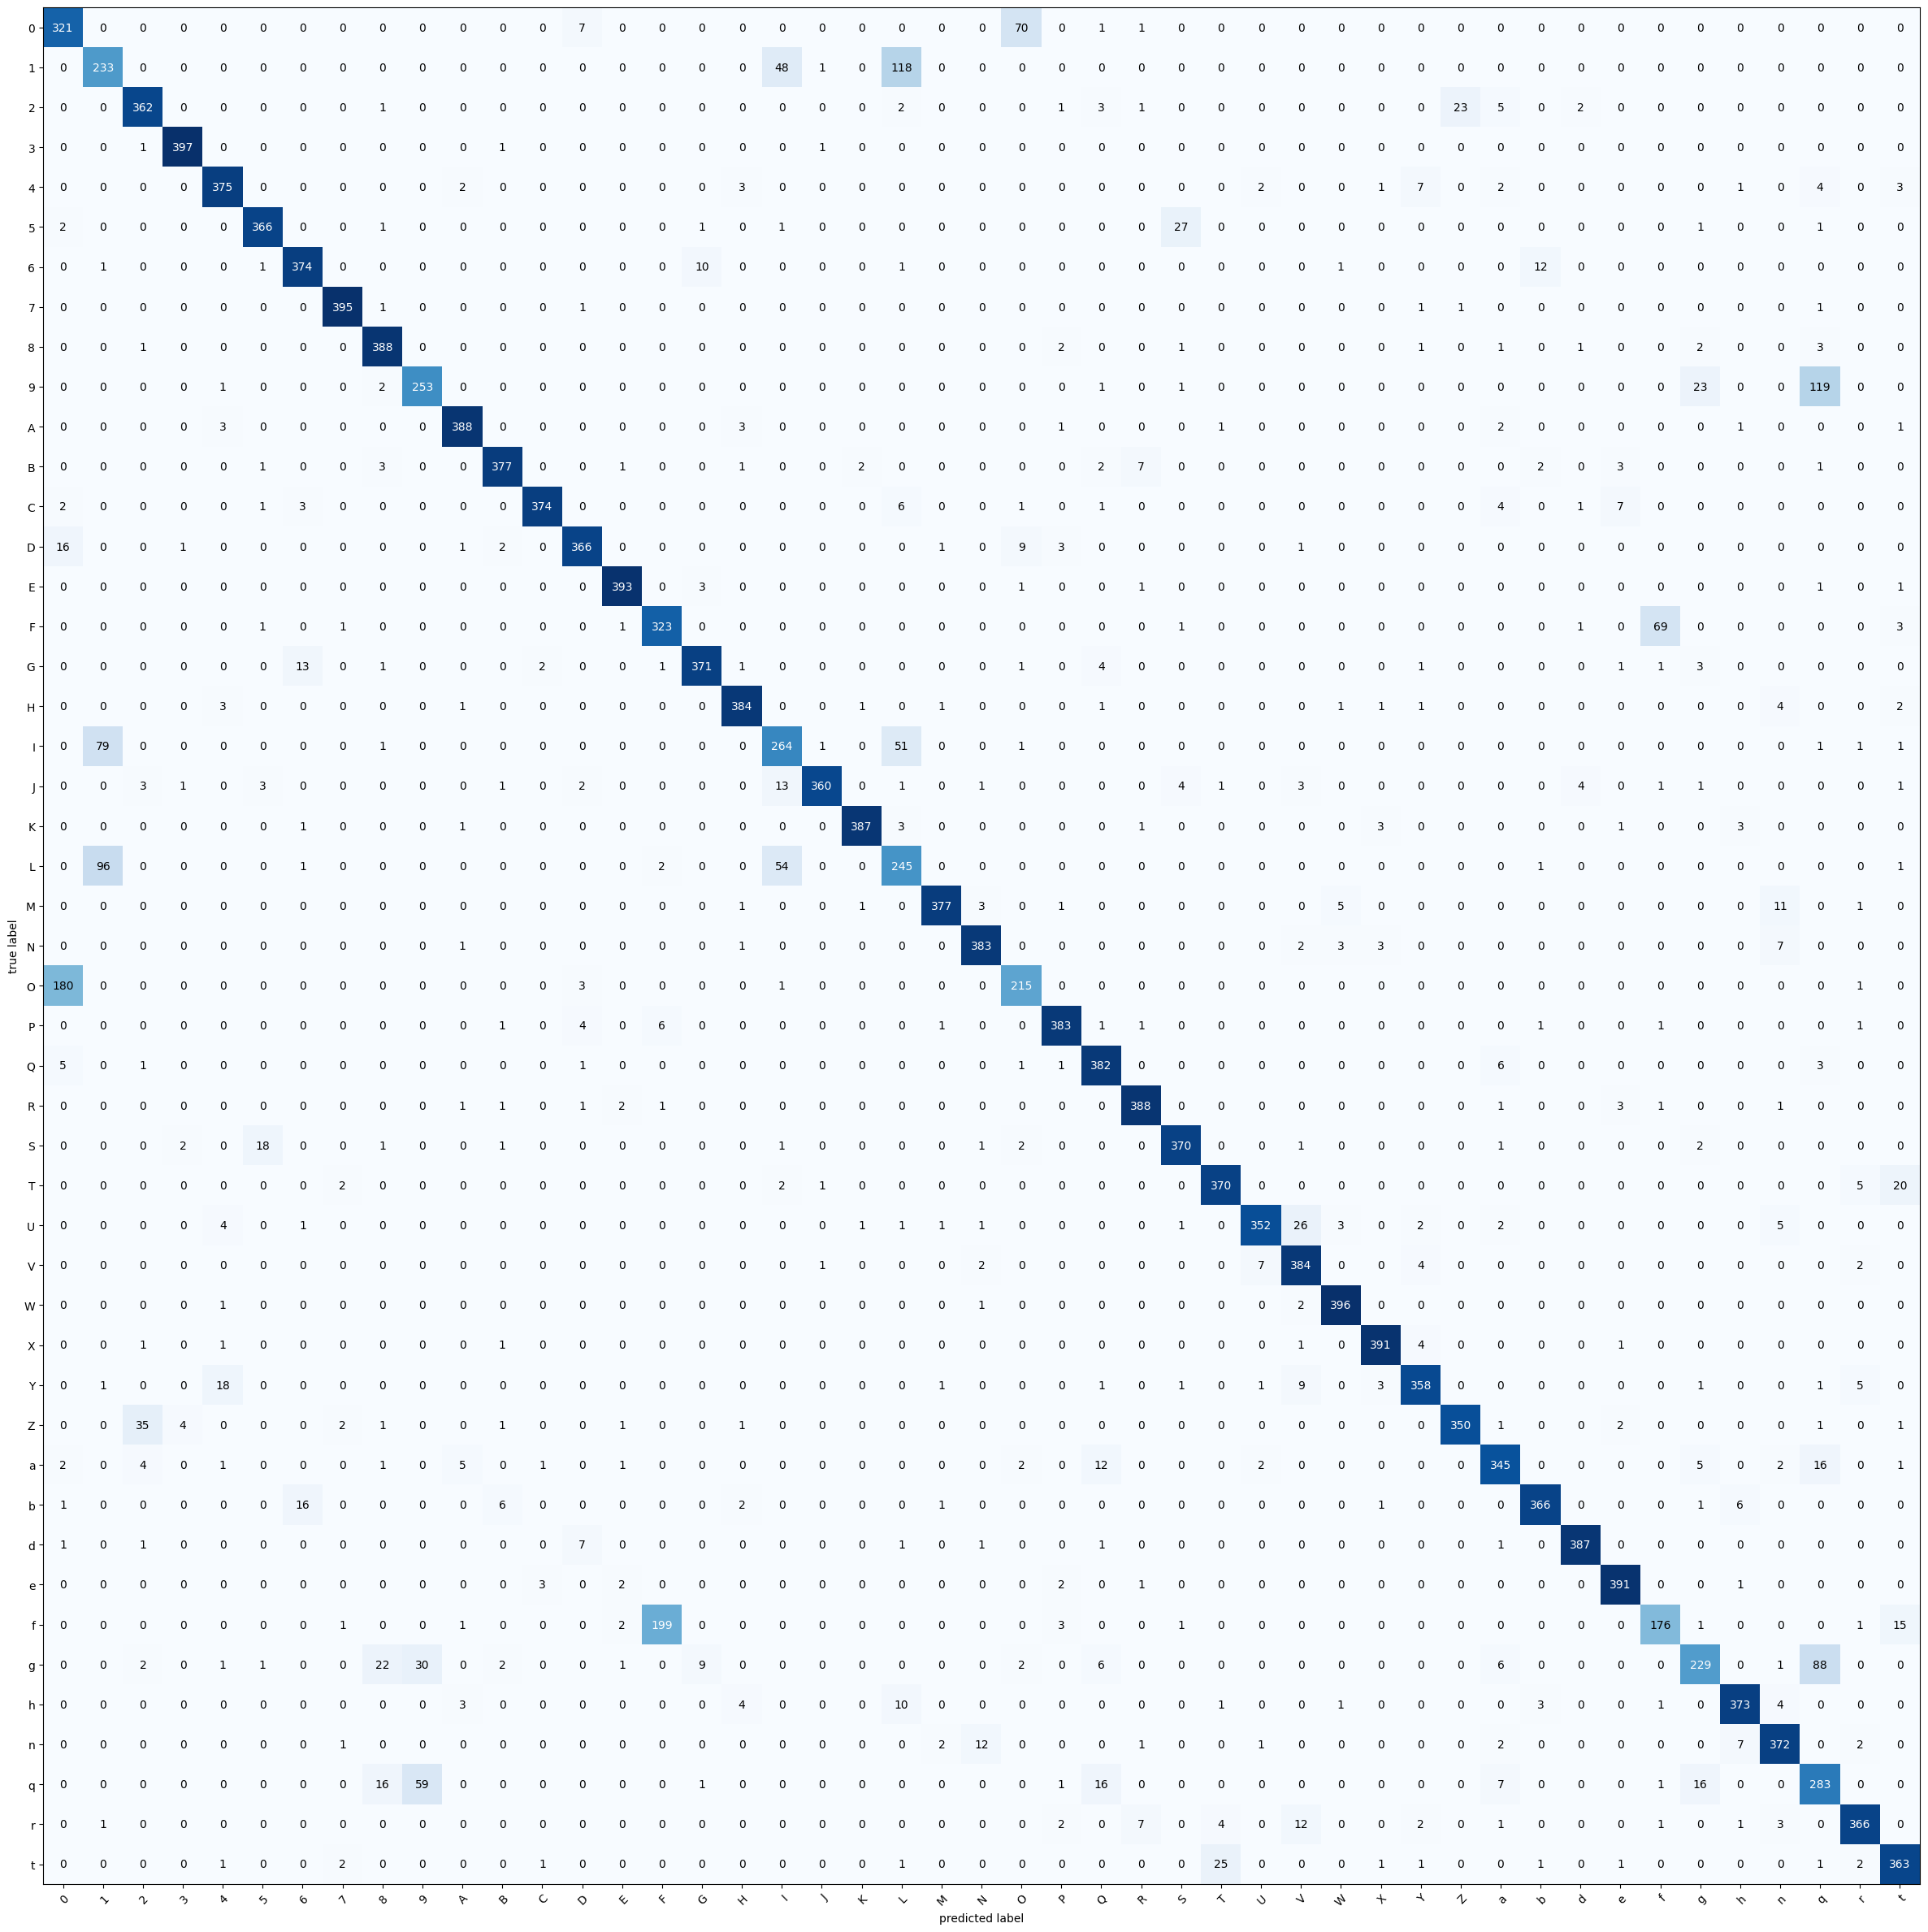

In [40]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets

all_targets = []
for _, label in test_data:
    all_targets.append(label)
all_targets = torch.tensor(all_targets)

# Ensure preds is a tensor
y_pred_tensor = torch.tensor(y_pred_tensor)
print(len(all_targets)/16)
# Setup the confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(labels_list), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=all_targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with NumPy
    class_names=labels_list,  # turn the row and column labels into class names
    figsize=(30, 30)
)

In [41]:
pytorch_total_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)
print(pytorch_total_params)

540879


In [42]:
best_model

ConvReLUKAN(
  (layer1): ConvReLUKANLayer(
    (convs): ModuleList(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (layer2): ConvReLUKANLayer(
    (convs): ModuleList(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (layer3): ConvReLUKANLayer(
    (convs): ModuleList(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (layer4): ConvReLUKANLayer(
    (convs): ModuleList(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (layer5): ConvReLUKANLayer(
    (convs): ModuleList(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=256, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=47, bias=True)
)